In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
import os
from google.colab import drive

# Define transforms with data augmentation for training data
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((56, 56)),  # Resize images to 56x56
        transforms.RandomHorizontalFlip(),  # Random horizontal flip
        transforms.RandomRotation(20),  # Random rotation
        transforms.ToTensor()  # Convert image to PyTorch Tensor data type
    ]),
    'val': transforms.Compose([
        transforms.Resize((56, 56)),  # Resize images to 56x56
        transforms.ToTensor()  # Convert image to PyTorch Tensor data type
    ]),
}

# Mount Google Drive
drive.mount('/content/drive')
root_path = '/content/drive/MyDrive/ODIR5K'

# Load the images from the different directories
dataset = ImageFolder(root_path, transform=data_transforms['train'])

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Apply different transformations to your training and validation sets
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from torchvision import models

# Load pre-trained GoogLeNet model and reset final fully connected layer
model = models.googlenet(pretrained=True)

# Number of input features for the last layer
n_inputs = model.fc.in_features

# Re-define the final fully connected layer (fc)
# Here, output should be 3 for 3 classes: 'normal', 'AMD', 'pathological myopia'
model.fc = nn.Sequential(
    nn.Linear(n_inputs, 2048),
    nn.ReLU(),
    nn.Dropout(0.4), # 40% dropout
    nn.Linear(2048, 3), # output layer with 3 classes
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

In [ ]:
# Loss function
# NLLLoss() as we're using LogSoftmax in the last layer
criterion = nn.NLLLoss()

# Adam optimizer with L2 regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01) # L2 regularization with lambda=0.01

Epoch 1/60
train Loss: 1.1117 Acc: 0.5025
val Loss: 0.8907 Acc: 0.5505
Epoch 2/60
train Loss: 1.0289 Acc: 0.4987
val Loss: 0.9914 Acc: 0.5859
Epoch 3/60
train Loss: 1.0504 Acc: 0.4710
val Loss: 0.9347 Acc: 0.5253
Epoch 4/60
train Loss: 1.0515 Acc: 0.4432
val Loss: 1.9141 Acc: 0.4293
Epoch 5/60
train Loss: 1.0349 Acc: 0.4924
val Loss: 1.0351 Acc: 0.5354
Epoch 6/60
train Loss: 1.0527 Acc: 0.4836
val Loss: 0.9950 Acc: 0.5152
Epoch 7/60
train Loss: 1.0411 Acc: 0.4747
val Loss: 1.0184 Acc: 0.5152
Epoch 8/60
train Loss: 1.0482 Acc: 0.4798
val Loss: 1.0101 Acc: 0.5152
Epoch 9/60
train Loss: 1.0470 Acc: 0.4798
val Loss: 1.0023 Acc: 0.5152
Epoch 10/60
train Loss: 1.0239 Acc: 0.4798
val Loss: 0.9494 Acc: 0.5152
Epoch 11/60
train Loss: 0.9714 Acc: 0.5088
val Loss: 0.9109 Acc: 0.6212
Epoch 12/60
train Loss: 0.9680 Acc: 0.5429
val Loss: 0.9148 Acc: 0.6364
Epoch 13/60
train Loss: 0.9420 Acc: 0.5530
val Loss: 0.8264 Acc: 0.6566
Epoch 14/60
train Loss: 0.9459 Acc: 0.5581
val Loss: 0.8789 Acc: 0.5960
E

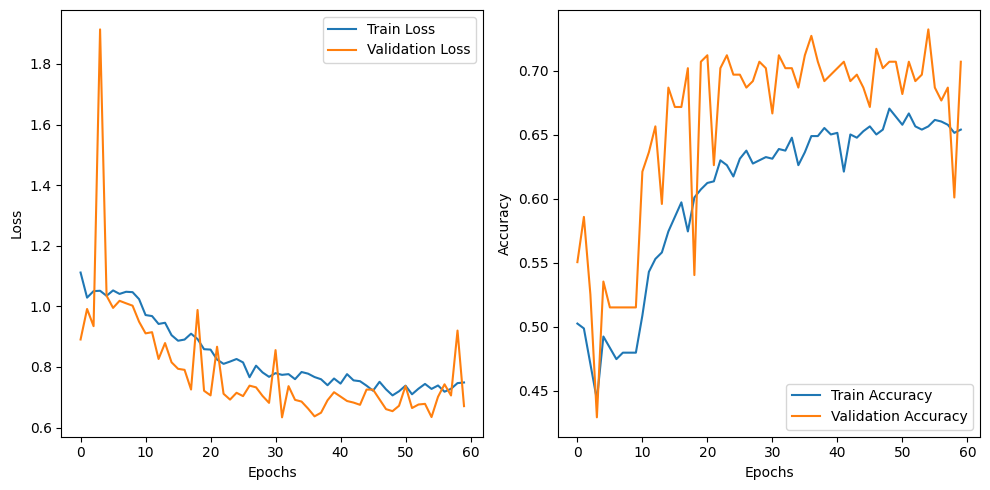

In [ ]:
import matplotlib.pyplot as plt

def train_model(model, criterion, optimizer, num_epochs=25):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

    return model, train_losses, val_losses, train_accs, val_accs

# Train the model
model, train_losses,val_losses, train_accs, val_accs = train_model(model, criterion, optimizer, num_epochs=60)


# Plotting train and validation losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting train and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()